# Predicting The Stock Market with Trump's Tweets
- James M. Irving
- james.irving.phd@gmail.com
- Updated 10/25/20

In [1]:
## Control Downloading fresh data
DOWNLOAD_DATA = False

> **Note to my students: You are not allowed to use any propriety functions from this notebook in your projects.**

In [2]:
## Set random seeds for reproducibility
import numpy as np
np.random.seed(321)

import tensorflow as tf
tf.random.set_seed(321)

# OBTAIN

### DATA SOURCES:

* **All Donald Trump tweets from 12/01/2016 (pre-inaugaration day) ~~to end of 08/23/2018~~**
    *          ~~Extracted from http://www.trumptwitterarchive.com/~~
    - Trump Twitter Archive 2.0 (now with API endpoint)
    - https://www.thetrumparchive.com/

* **Minute-resolution data for the S&P500 covering the same time period.**
    *         IVE S&P500 Index from - http://www.kibot.com/free_historical_data.aspx
    - (***Aggregate 1 min bid-ask data link***)
        - http://api.kibot.com/?action=history&symbol=IVE&interval=tickbidask1&bp=1&user=guest
    
    
* NOTE: Both sources required manual extraction and both 1-min historical stock data and batch-historical-tweet data are difficult to obtain without paying \\$150-\\$2000 monthly developer memberships. 

In [3]:
import os,sys,glob,time
sys.path.append('py_files/')

## IMPORT CUSTOM CAPSTONE FUNCTIONS
import functions_combined_BEST as ji
import functions_io as io

## Import data downloading packages
import datetime as dt
import requests
import pandas as pd
import json

In [4]:
# !pip install -U fsds
from fsds.imports import *

fsds v0.2.27 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


In [5]:
def download_stock_data(fpath='data/ive_minute_tick_bidask_API.csv',
                       verbose=True,append_date=True):
    """Downloads up-to-date IVE S&P 500 1-min aggregate data from 
    http://www.kibot.com/free_historical_data.aspx
    
    Args:
        fpath (str): csv filepath to save (Default='data/ive_minute_tick_bidask_API.csv')
        verbose (bool): Display file info (Default=True)
        
    Returns:
        stock_df: DataFrame with correct headers and datetime index"""
    agg_url = 'http://api.kibot.com/?action=history&symbol=IVE&interval=tickbidask1&bp=1&user=guest'
    response = requests.get(agg_url,
                            allow_redirects=True)

    ## Save output to csv file
    with open(fpath,'wb') as file:
        file.write(response.content)
        
        
    ## Load in Stock Data Frame with headers (then save)
    headers = ['Date','Time','BidOpen','BidHigh','BidLow','BidClose','AskOpen','AskHigh','AskLow','AskClose']
    stock_df = pd.read_csv(fpath,names=headers)

# 
    ## Make Combined Date Time column and Drop Origs
    stock_df['datetime'] = pd.to_datetime(stock_df['Date'].astype(str)+' '+stock_df['Time'].astype(str))
    
    if append_date:
        suffix = dt.date.today().strftime('%m-%d-%y')
        fpath = f"{fpath.split('.csv')[0]}_{suffix}.csv"
        
    print(f'Saving as {fpath}')
    stock_df.to_csv(fpath,index=False)
        
    if verbose:
        print('[i] Stock data successfully downloaded and saved as:')
        print(' - ',fpath)
        
    return pd.read_csv(fpath,parse_dates=['datetime'],index_col='datetime')

In [6]:
def download_trump_tweets(fpath='data/trump_tweets.csv',append_date=True,
                          verbose=True,return_data=True):
    """Downloads the most recent data from the trumptwittearchive v2.
    https://drive.google.com/uc?export=download&id=1JZnhB0Nq_2RKtDb-IOnd0XxnD5c7x-nQ
    
    Args:
        fpath (str): filepath for data that ends with .csv
        append_date (bool): Whether to save today's date as part of filename(Default=True)
        verbose (bool): Whether to print the file name (Default=True)
        return_data (bool): Whether to return the data as a df (Default=True)"""
#     url = "https://www.thetrumparchive.com/latest-tweets"
    url="https://drive.google.com/uc?export=download&id=1JZnhB0Nq_2RKtDb-IOnd0XxnD5c7x-nQ"
    response = requests.get(url)
    
    if append_date:
        suffix = "_"+dt.date.today().strftime('%m-%d-%y')
        filepath = f"{fpath.split('.')[0]}{suffix}.{fpath.split('.')[-1]}"
    else:
        filepath=fpath
        
        
    ## Save output to csv file
    with open(filepath,'wb') as file:
        file.write(response.content)  
        
#     with open(filepath,'w') as f:
# #         f.write(response.content)
#         f.write(json.dumps(response.json()))
    
#     if fpath.endswith('.csv'):
#         tweets = pd.read_json(filepath)
#         tweets.to_csv(filepath)
#     else: 
#         tweets = pd.read_json(filepath)
        
    if verbose:
        print('[i] Tweet data successfully downloaded and saved as:')
        print('- ',filepath)
        
    if return_data:

        return pd.read_csv(filepath,index_col=0,parse_dates=['date'])
#tweets#,parse_dates=['created_at'])

In [7]:
## DOWNLOAD THE DATA IF REQUESTED
if DOWNLOAD_DATA:
    print('[i] Downoading data sets...')
    stock_df = download_stock_data()
    tweets = download_trump_tweets()
    
else: 
    print('[i] Loading most recent data sets...')
    ## Get list of current csvs
    files_glob = glob.glob('data/*.csv')
    stock_files = list(filter(lambda x: 'ive_minute' in x, files_glob))
    tweet_files = list(filter(lambda x: 'tweet' in x, files_glob))


    ## make dictionaries of file date modifieds
    TWEET_FILES = {}
    for file in tweet_files:
        TWEET_FILES[file] = pd.to_datetime(time.ctime(os.path.getmtime(file)))

    STOCK_FILES = {}
    for file in stock_files:
        STOCK_FILES[file] = pd.to_datetime(time.ctime(os.path.getmtime(file)))

        
    ## Get most recent files
    recent_stocks = pd.Series(STOCK_FILES).idxmax()
    recent_tweets = pd.Series(TWEET_FILES).idxmax()
    
    ## Load in the csvs 
    tweets = pd.read_csv(recent_tweets,parse_dates=['date'],index_col='date')
    stock_df = pd.read_csv(recent_stocks,parse_dates=['datetime'],index_col='datetime')
    
    ## Sort timeseries
    tweets.sort_index(inplace=True)
    stock_df.sort_index(inplace=True)
## Display Preview of DFs
display(stock_df.head(),tweets.head())

[i] Loading most recent data sets...


,Date,Time,BidOpen,BidHigh,BidLow,BidClose,AskOpen,AskHigh,AskLow,AskClose
datetime,,,,,,,,,,
2009-09-28 09:30:00,09/28/2009,09:30,39.06,39.06,39.06,39.06,39.13,39.13,39.13,39.13
2009-09-28 09:31:00,09/28/2009,09:31,39.10,39.10,39.08,39.09,39.11,39.11,39.10,39.11
2009-09-28 09:32:00,09/28/2009,09:32,39.11,39.15,39.11,39.15,39.12,39.16,39.12,39.16
2009-09-28 09:33:00,09/28/2009,09:33,39.14,39.14,39.14,39.14,39.15,39.16,39.15,39.15
2009-09-28 09:34:00,09/28/2009,09:34,39.14,39.14,39.12,39.12,39.15,39.15,39.14,39.14


,date-corrected,id,text,isRetweet,isDeleted,device,favorites,retweets,stock_time,tweet_minute,tweet_minute_price,stock_time_price,delta_price,delta_bins,price_bins,target,quantile_bins
date,,,,,,,,,,,,,,,,,
2009-09-29 15:28:23,2009-09-29 11:28:23,4472353826,"""""""A lot of people have imagination, but can't...",f,f,Twitter Web Client,138,74,2009-09-29 12:29:00,2009-09-29 11:29:00,39.73,39.67,-0.06,no change,no change,no change,no change
2009-10-05 14:37:38,2009-10-05 10:37:38,4629116949,- Read what Donald Trump has to say about daug...,f,f,Twitter Web Client,14,10,2009-10-05 11:38:00,2009-10-05 10:38:00,38.56,38.57,0.01,no change,no change,no change,no change
2009-10-14 14:13:17,2009-10-14 10:13:17,4862580190,Watch video of Ivanka Trump sharing business a...,f,f,Twitter Web Client,19,12,2009-10-14 11:14:00,2009-10-14 10:14:00,40.46,40.51,0.05,no change,no change,no change,no change
2009-10-27 15:31:48,2009-10-27 11:31:48,5203117820,"""--From Donald Trump: """"Ivanka and Jared’s wed...",f,f,Twitter Web Client,14,11,2009-10-27 12:32:00,2009-10-27 11:32:00,39.26,39.19,-0.07,no change,no change,no change,no change
2009-11-02 14:57:56,2009-11-02 10:57:56,5364614040,"--Work has begun, ahead of schedule, to build ...",f,f,Twitter Web Client,12,12,2009-11-02 11:58:00,2009-11-02 10:58:00,38.49,38.50,0.01,no change,no change,no change,no change


In [8]:
stock_df.shape, tweets.shape

((913056, 10), (8721, 17))

# Creating the Target

In [9]:
stock_df = stock_df[['BidClose']].sort_index()#.reset_index()#.asfreq('T')
stock_df

,BidClose
datetime,
2009-09-28 09:30:00,39.06
2009-09-28 09:31:00,39.09
2009-09-28 09:32:00,39.15
2009-09-28 09:33:00,39.14
2009-09-28 09:34:00,39.12
...,...
2020-10-23 15:56:00,116.83
2020-10-23 15:57:00,116.86
2020-10-23 15:58:00,116.82


## Stock Preprocessing

In [10]:
# ## Remove rare 0-values
stock_df = stock_df[~(stock_df==0).any(axis=1)]
stock_df.shape

(913039, 1)

<AxesSubplot:xlabel='datetime'>

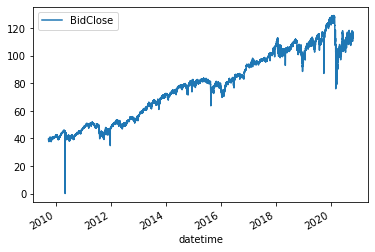

In [11]:
stock_df.plot()

In [12]:
## Now, convert stock_df to minute frequency
stock_df = stock_df.asfreq('T')
stock_df.index

DatetimeIndex(['2009-09-28 09:30:00', '2009-09-28 09:31:00',
               '2009-09-28 09:32:00', '2009-09-28 09:33:00',
               '2009-09-28 09:34:00', '2009-09-28 09:35:00',
               '2009-09-28 09:36:00', '2009-09-28 09:37:00',
               '2009-09-28 09:38:00', '2009-09-28 09:39:00',
               ...
               '2020-10-23 15:51:00', '2020-10-23 15:52:00',
               '2020-10-23 15:53:00', '2020-10-23 15:54:00',
               '2020-10-23 15:55:00', '2020-10-23 15:56:00',
               '2020-10-23 15:57:00', '2020-10-23 15:58:00',
               '2020-10-23 15:59:00', '2020-10-23 16:00:00'],
              dtype='datetime64[ns]', name='datetime', length=5822311, freq='T')

In [13]:
stock_df.isna().sum()

BidClose    4909272
dtype: int64

In [14]:
# (stock_df==0).sum()

## Tweet Processing

In [15]:
display(tweets.head(),tweets.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8721 entries, 2009-09-29 15:28:23 to 2020-10-23 18:45:47
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date-corrected      8721 non-null   object 
 1   id                  8721 non-null   int64  
 2   text                8721 non-null   object 
 3   isRetweet           8721 non-null   object 
 4   isDeleted           8721 non-null   object 
 5   device              8721 non-null   object 
 6   favorites           8721 non-null   int64  
 7   retweets            8721 non-null   int64  
 8   stock_time          8721 non-null   object 
 9   tweet_minute        8721 non-null   object 
 10  tweet_minute_price  8721 non-null   float64
 11  stock_time_price    8721 non-null   float64
 12  delta_price         8721 non-null   float64
 13  delta_bins          8721 non-null   object 
 14  price_bins          8721 non-null   object 
 15  target             

,date-corrected,id,text,isRetweet,isDeleted,device,favorites,retweets,stock_time,tweet_minute,tweet_minute_price,stock_time_price,delta_price,delta_bins,price_bins,target,quantile_bins
date,,,,,,,,,,,,,,,,,
2009-09-29 15:28:23,2009-09-29 11:28:23,4472353826,"""""""A lot of people have imagination, but can't...",f,f,Twitter Web Client,138,74,2009-09-29 12:29:00,2009-09-29 11:29:00,39.73,39.67,-0.06,no change,no change,no change,no change
2009-10-05 14:37:38,2009-10-05 10:37:38,4629116949,- Read what Donald Trump has to say about daug...,f,f,Twitter Web Client,14,10,2009-10-05 11:38:00,2009-10-05 10:38:00,38.56,38.57,0.01,no change,no change,no change,no change
2009-10-14 14:13:17,2009-10-14 10:13:17,4862580190,Watch video of Ivanka Trump sharing business a...,f,f,Twitter Web Client,19,12,2009-10-14 11:14:00,2009-10-14 10:14:00,40.46,40.51,0.05,no change,no change,no change,no change
2009-10-27 15:31:48,2009-10-27 11:31:48,5203117820,"""--From Donald Trump: """"Ivanka and Jared’s wed...",f,f,Twitter Web Client,14,11,2009-10-27 12:32:00,2009-10-27 11:32:00,39.26,39.19,-0.07,no change,no change,no change,no change
2009-11-02 14:57:56,2009-11-02 10:57:56,5364614040,"--Work has begun, ahead of schedule, to build ...",f,f,Twitter Web Client,12,12,2009-11-02 11:58:00,2009-11-02 10:58:00,38.49,38.50,0.01,no change,no change,no change,no change


None

### Finding the Matching Tweets/Stock Data

In [16]:
tweets.reset_index()['date'].dt.ceil('T')

0      2009-09-29 15:29:00
1      2009-10-05 14:38:00
2      2009-10-14 14:14:00
3      2009-10-27 15:32:00
4      2009-11-02 14:58:00
               ...        
8716   2020-10-23 16:56:00
8717   2020-10-23 17:10:00
8718   2020-10-23 17:55:00
8719   2020-10-23 18:41:00
8720   2020-10-23 18:46:00
Name: date, Length: 8721, dtype: datetime64[ns]

In [17]:
import math


In [18]:
tweets[tweets['text'].str.contains('Sleepy Joe')]#.tail(20)]

,date-corrected,id,text,isRetweet,isDeleted,device,favorites,retweets,stock_time,tweet_minute,tweet_minute_price,stock_time_price,delta_price,delta_bins,price_bins,target,quantile_bins
date,,,,,,,,,,,,,,,,,
2019-04-29 14:51:03,2019-04-29 10:51:03,1122875949933051904,Sleepy Joe Biden is having his first rally in ...,f,f,Twitter for iPhone,67529,14946,2019-04-29 11:52:00,2019-04-29 10:52:00,112.75,112.75,0.00,no change,no change,no change,no change
2019-05-20 14:08:04,2019-05-20 10:08:04,1130475280164896768,Looks like Bernie Sanders is history. Sleepy J...,f,f,Twitter for iPhone,99247,20847,2019-05-20 11:09:00,2019-05-20 10:09:00,108.52,108.44,-0.08,no change,no change,no change,no change
2019-07-11 15:52:19,2019-07-11 11:52:19,1149345681829744647,"...years, or maybe 10 or 14 (just kidding), th...",f,f,Twitter for iPhone,42586,8771,2019-07-11 12:53:00,2019-07-11 11:53:00,114.41,114.39,-0.02,no change,no change,no change,no change
2019-07-26 13:58:15,2019-07-26 09:58:15,1154752797637783552,.@FoxNews is at it again. So different from wh...,f,f,Twitter for iPhone,77244,14269,2019-07-26 10:59:00,2019-07-26 09:59:00,115.41,115.54,0.13,increase,no change,no change,increase
2019-10-09 17:55:33,2019-10-09 13:55:33,1181991604493656064,"So pathetic to see Sleepy Joe Biden, who with ...",f,f,Twitter for iPhone,96621,22630,2019-10-09 14:56:00,2019-10-09 13:56:00,113.29,113.42,0.13,no change,no change,no change,no change
2019-10-09 18:12:21,2019-10-09 14:12:21,1181995834369544198,Sleepy Joe Biden! https://t.co/oZtytImXqq,f,f,Twitter for iPhone,73068,24490,2019-10-09 15:13:00,2019-10-09 14:13:00,113.26,113.53,0.27,increase,increase,increase,increase
2019-11-07 14:51:38,2019-11-07 10:51:38,1192454569936216065,“What did Hunter Biden do for the money?” @Sen...,f,f,Twitter for iPhone,50654,13446,2019-11-07 11:52:00,2019-11-07 10:52:00,122.51,122.36,-0.15,decrease,no change,no change,decrease
2019-12-20 18:18:27,2019-12-20 14:18:27,1208089293308211202,"I guess the magazine, “Christianity Today,” is...",f,f,Twitter for iPhone,106200,21743,2019-12-20 15:19:00,2019-12-20 14:19:00,127.17,127.24,0.07,no change,no change,no change,no change
2020-03-04 15:40:01,2020-03-04 11:40:01,1235228511314620416,Mini Mike Bloomberg just “quit” the race for P...,f,f,Twitter for iPhone,136024,25323,2020-03-04 12:41:00,2020-03-04 11:41:00,115.70,116.15,0.45,increase,increase,increase,increase


In [19]:
## Fixing Tweet Timestamps
## Obama is campaining for us. Tweet
test_ts = '2020-10-22 15:26'
tweets_df_ts = pd.to_datetime(test_ts)
twitter_ts = pd.to_datetime('11:26 AM  Oct 22, 2020')
twitter_ts,tweets_df_ts

(Timestamp('2020-10-22 11:26:00'), Timestamp('2020-10-22 15:26:00'))

In [20]:
tweets.loc[test_ts]

,date-corrected,id,text,isRetweet,isDeleted,device,favorites,retweets,stock_time,tweet_minute,tweet_minute_price,stock_time_price,delta_price,delta_bins,price_bins,target,quantile_bins
date,,,,,,,,,,,,,,,,,
2020-10-22 15:26:26,2020-10-22 11:26:26,1319299079264940039,Obama is campaigning for us. Every time he spe...,f,f,Twitter for iPhone,206025,36232,2020-10-22 12:27:00,2020-10-22 11:27:00,115.93,115.9,-0.03,no change,no change,no change,no change


In [21]:
# tweets[tweets['text'].str.contains('covfefe')]

In [22]:
# tweets[tweets['text'].str.contains('covfefe')]


In [23]:
# ## Second test_ts to verify time delay
# test_ts2 = "2017-05-31 04:06"
# tweets_df_ts2 = pd.to_datetime(test_ts2)#tweets[tweets['text'].str.contains('covfefe')].index[0]

# twitter_ts2 = pd.to_datetime('6:09 AM  May 31, 2017')
# twitter_ts2,tweets_df_ts2

In [24]:
# tweets_df_ts.tz

In [25]:
## save tdelta to use to fix tweet timestamps
tdelta = pd.to_timedelta(tweets_df_ts - twitter_ts,unit='min')
tdelta

Timedelta('0 days 04:00:00')

In [26]:
# ## save tdelta to use to fix tweet timestamps
# tdelta2 = pd.to_timedelta(tweets_df_ts2 - twitter_ts2,unit='min')
# tdelta2

### Making `date-corrected`

In [27]:
## Making Corrected Date
tweets['date-corrected'] = tweets.index - tdelta
tweets

,date-corrected,id,text,isRetweet,isDeleted,device,favorites,retweets,stock_time,tweet_minute,tweet_minute_price,stock_time_price,delta_price,delta_bins,price_bins,target,quantile_bins
date,,,,,,,,,,,,,,,,,
2009-09-29 15:28:23,2009-09-29 11:28:23,4472353826,"""""""A lot of people have imagination, but can't...",f,f,Twitter Web Client,138,74,2009-09-29 12:29:00,2009-09-29 11:29:00,39.73,39.67,-0.06,no change,no change,no change,no change
2009-10-05 14:37:38,2009-10-05 10:37:38,4629116949,- Read what Donald Trump has to say about daug...,f,f,Twitter Web Client,14,10,2009-10-05 11:38:00,2009-10-05 10:38:00,38.56,38.57,0.01,no change,no change,no change,no change
2009-10-14 14:13:17,2009-10-14 10:13:17,4862580190,Watch video of Ivanka Trump sharing business a...,f,f,Twitter Web Client,19,12,2009-10-14 11:14:00,2009-10-14 10:14:00,40.46,40.51,0.05,no change,no change,no change,no change
2009-10-27 15:31:48,2009-10-27 11:31:48,5203117820,"""--From Donald Trump: """"Ivanka and Jared’s wed...",f,f,Twitter Web Client,14,11,2009-10-27 12:32:00,2009-10-27 11:32:00,39.26,39.19,-0.07,no change,no change,no change,no change
2009-11-02 14:57:56,2009-11-02 10:57:56,5364614040,"--Work has begun, ahead of schedule, to build ...",f,f,Twitter Web Client,12,12,2009-11-02 11:58:00,2009-11-02 10:58:00,38.49,38.50,0.01,no change,no change,no change,no change
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-23 16:55:29,2020-10-23 12:55:29,1319683876046934016,HUGE win today for the United States and for p...,f,f,Twitter for iPhone,211044,50959,2020-10-23 13:56:00,2020-10-23 12:56:00,116.30,116.62,0.32,increase,increase,increase,increase
2020-10-23 17:09:21,2020-10-23 13:09:21,1319687368014704642,Today is the LAST DAY to register to VOTE in-p...,f,f,Twitter for iPhone,52213,10785,2020-10-23 14:10:00,2020-10-23 13:10:00,116.40,116.64,0.24,increase,no change,no change,increase
2020-10-23 17:54:01,2020-10-23 13:54:01,1319698607851868160,RT @IvankaTrump: Yesterday @realDonaldTrump gr...,t,f,Twitter for iPhone,0,46485,2020-10-23 14:55:00,2020-10-23 13:55:00,116.59,116.77,0.18,increase,no change,no change,increase


In [28]:
## Make new date-corrected index
tweets = tweets.reset_index(drop=False).set_index('date-corrected')

In [29]:
## Getting first, alst stock_df
first_stock_ts = stock_df.index[0]
last_stock_ts = stock_df.index[-1]
first_stock_ts,last_stock_ts

(Timestamp('2009-09-28 09:30:00', freq='T'),
 Timestamp('2020-10-23 16:00:00', freq='T'))

In [30]:
first_tweet_ts = tweets.index[0]
last_tweet_ts = tweets.index[-1]
first_tweet_ts,last_tweet_ts

(Timestamp('2009-09-29 11:28:23'), Timestamp('2020-10-23 14:45:47'))

In [31]:
## MAKING DF TIME PERIODS MATCH
stock_df = stock_df.loc[first_tweet_ts:]
stock_df

,BidClose
datetime,
2009-09-29 11:29:00,39.73
2009-09-29 11:30:00,39.73
2009-09-29 11:31:00,39.74
2009-09-29 11:32:00,39.72
2009-09-29 11:33:00,39.71
...,...
2020-10-23 15:56:00,116.83
2020-10-23 15:57:00,116.86
2020-10-23 15:58:00,116.82


In [32]:
## Cutting both dfs to match the timespan of the other
tweets = tweets.loc[first_stock_ts:last_stock_ts-pd.to_timedelta('60T')]
tweets

,date,id,text,isRetweet,isDeleted,device,favorites,retweets,stock_time,tweet_minute,tweet_minute_price,stock_time_price,delta_price,delta_bins,price_bins,target,quantile_bins
date-corrected,,,,,,,,,,,,,,,,,
2009-09-29 11:28:23,2009-09-29 15:28:23,4472353826,"""""""A lot of people have imagination, but can't...",f,f,Twitter Web Client,138,74,2009-09-29 12:29:00,2009-09-29 11:29:00,39.73,39.67,-0.06,no change,no change,no change,no change
2009-10-05 10:37:38,2009-10-05 14:37:38,4629116949,- Read what Donald Trump has to say about daug...,f,f,Twitter Web Client,14,10,2009-10-05 11:38:00,2009-10-05 10:38:00,38.56,38.57,0.01,no change,no change,no change,no change
2009-10-14 10:13:17,2009-10-14 14:13:17,4862580190,Watch video of Ivanka Trump sharing business a...,f,f,Twitter Web Client,19,12,2009-10-14 11:14:00,2009-10-14 10:14:00,40.46,40.51,0.05,no change,no change,no change,no change
2009-10-27 11:31:48,2009-10-27 15:31:48,5203117820,"""--From Donald Trump: """"Ivanka and Jared’s wed...",f,f,Twitter Web Client,14,11,2009-10-27 12:32:00,2009-10-27 11:32:00,39.26,39.19,-0.07,no change,no change,no change,no change
2009-11-02 10:57:56,2009-11-02 14:57:56,5364614040,"--Work has begun, ahead of schedule, to build ...",f,f,Twitter Web Client,12,12,2009-11-02 11:58:00,2009-11-02 10:58:00,38.49,38.50,0.01,no change,no change,no change,no change
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-23 12:55:29,2020-10-23 16:55:29,1319683876046934016,HUGE win today for the United States and for p...,f,f,Twitter for iPhone,211044,50959,2020-10-23 13:56:00,2020-10-23 12:56:00,116.30,116.62,0.32,increase,increase,increase,increase
2020-10-23 13:09:21,2020-10-23 17:09:21,1319687368014704642,Today is the LAST DAY to register to VOTE in-p...,f,f,Twitter for iPhone,52213,10785,2020-10-23 14:10:00,2020-10-23 13:10:00,116.40,116.64,0.24,increase,no change,no change,increase
2020-10-23 13:54:01,2020-10-23 17:54:01,1319698607851868160,RT @IvankaTrump: Yesterday @realDonaldTrump gr...,t,f,Twitter for iPhone,0,46485,2020-10-23 14:55:00,2020-10-23 13:55:00,116.59,116.77,0.18,increase,no change,no change,increase


### Making Target

In [33]:
def make_target_columns(tweets,stock_df,offset='60T',drop_nulls=False):
    ## Get start_ts (tweet_minute) and end_ts (tweet_minute+target_offset)
    df = tweets.copy()
    target_offset = pd.to_timedelta(offset)

    ## Fill in new stock_time column
    df['stock_time'] = df.index + target_offset 
    df['stock_time'] = df['stock_time'].dt.ceil('T')
    
    ## Fill in Minute Used for Tweet Lookup
    df['tweet_minute'] = df.index.ceil('T')
    
    ## Retrieve Tweet Prices
    df['tweet_minute_price'] = df['tweet_minute'].apply(lambda x: stock_df.loc[x])
    
    ## Retrieve Target-Timedelta Prices
    df['stock_time_price'] = df['stock_time'].apply(lambda x: stock_df.loc[x])


    if drop_nulls:
        df = df[~df.isna().any(axis=1)].copy()
    
    return df

In [34]:
twitter_df = make_target_columns(tweets,stock_df,offset='60T',drop_nulls=True)
twitter_df

,date,id,text,isRetweet,isDeleted,device,favorites,retweets,stock_time,tweet_minute,tweet_minute_price,stock_time_price,delta_price,delta_bins,price_bins,target,quantile_bins
date-corrected,,,,,,,,,,,,,,,,,
2009-09-29 11:28:23,2009-09-29 15:28:23,4472353826,"""""""A lot of people have imagination, but can't...",f,f,Twitter Web Client,138,74,2009-09-29 12:29:00,2009-09-29 11:29:00,39.73,39.67,-0.06,no change,no change,no change,no change
2009-10-05 10:37:38,2009-10-05 14:37:38,4629116949,- Read what Donald Trump has to say about daug...,f,f,Twitter Web Client,14,10,2009-10-05 11:38:00,2009-10-05 10:38:00,38.56,38.57,0.01,no change,no change,no change,no change
2009-10-14 10:13:17,2009-10-14 14:13:17,4862580190,Watch video of Ivanka Trump sharing business a...,f,f,Twitter Web Client,19,12,2009-10-14 11:14:00,2009-10-14 10:14:00,40.46,40.51,0.05,no change,no change,no change,no change
2009-10-27 11:31:48,2009-10-27 15:31:48,5203117820,"""--From Donald Trump: """"Ivanka and Jared’s wed...",f,f,Twitter Web Client,14,11,2009-10-27 12:32:00,2009-10-27 11:32:00,39.26,39.19,-0.07,no change,no change,no change,no change
2009-11-02 10:57:56,2009-11-02 14:57:56,5364614040,"--Work has begun, ahead of schedule, to build ...",f,f,Twitter Web Client,12,12,2009-11-02 11:58:00,2009-11-02 10:58:00,38.49,38.50,0.01,no change,no change,no change,no change
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-23 12:55:29,2020-10-23 16:55:29,1319683876046934016,HUGE win today for the United States and for p...,f,f,Twitter for iPhone,211044,50959,2020-10-23 13:56:00,2020-10-23 12:56:00,116.30,116.62,0.32,increase,increase,increase,increase
2020-10-23 13:09:21,2020-10-23 17:09:21,1319687368014704642,Today is the LAST DAY to register to VOTE in-p...,f,f,Twitter for iPhone,52213,10785,2020-10-23 14:10:00,2020-10-23 13:10:00,116.40,116.64,0.24,increase,no change,no change,increase
2020-10-23 13:54:01,2020-10-23 17:54:01,1319698607851868160,RT @IvankaTrump: Yesterday @realDonaldTrump gr...,t,f,Twitter for iPhone,0,46485,2020-10-23 14:55:00,2020-10-23 13:55:00,116.59,116.77,0.18,increase,no change,no change,increase


In [35]:
## Save csv
twitter_df.to_csv('data/trump_tweets_plus_stock_prices.csv')

In [36]:
twitter_df['delta_price'] = twitter_df['stock_time_price'] - twitter_df['tweet_minute_price']

In [37]:
twitter_df['delta_price'].describe()

count    8721.000000
mean        0.000181
std         0.325618
min        -2.820000
25%        -0.090000
50%         0.010000
75%         0.100000
max        10.560000
Name: delta_price, dtype: float64

In [38]:
import plotly.express as px
px.histogram(twitter_df['delta_price'])

In [39]:
## Examining Using Quantiles for Target
target_quantiles = [0,.2,.8,1.]
np.quantile(twitter_df['delta_price'],target_quantiles)

array([-2.82, -0.13,  0.13, 10.56])

In [40]:
## Making binned target
twitter_df['quantile_bins'] = pd.qcut(twitter_df['delta_price'],target_quantiles,
                     labels=['decrease','no change','increase'])
twitter_df['quantile_bins'].value_counts()

no change    5226
decrease     1775
increase     1720
Name: quantile_bins, dtype: int64

In [41]:
## Examining using price cutoffs
target_price_bin_cutoffs = [-np.inf,-.25,+.25,np.inf]
twitter_df['price_bins'] = pd.cut(twitter_df['delta_price'],target_price_bin_cutoffs,
                           labels=['decrease','no change','increase'])
twitter_df['price_bins'].value_counts(dropna=False,normalize=True)

no change    0.811719
decrease     0.100333
increase     0.087949
Name: price_bins, dtype: float64

In [42]:
## Pick which column should be the target_bins
twitter_df['target'] = twitter_df['price_bins']

In [43]:
# def make_target_columns(tweets,stock_df,offset='60T',drop_nulls=False):
#     ## Get start_ts (tweet_minute) and end_ts (tweet_minute+target_offset)
#     df = tweets.copy()
#     target_offset = pd.to_timedelta(offset)

#     ## Fill in new stock_time column
#     df['stock_time'] = df.index + target_offset 
#     df['stock_time'] = df['stock_time'].dt.ceil('T')
    
#     ## Fill in Minute Used for Tweet Lookup
#     df['tweet_minute'] = df.index.ceil('T')
    
#     ## Retrieve Tweet Prices
#     df['tweet_minute_price'] = df['tweet_minute'].apply(lambda x: stock_df.loc[x])
#     ## Retrieve Target-Timedelta Prices
#     df['stock_time_price'] = df['stock_time'].apply(lambda x: stock_df.loc[x])

#     if drop_nulls:
#         df = df[~df.isna().any(axis=1)].copy()
    
#     return df

# twitter_df = make_target_columns(tweets,stock_df,offset='60T',drop_nulls=True)

In [44]:
import plotly.express as px
px.histogram(twitter_df,x='delta_price',color='target')

In [45]:
twitter_df.to_csv('data/trump_tweets_plus_target.csv')

# Delta Stock Price Classification Models

## BOOKMARK: CHANGING TASK TO FINDING TRUMP TO TROUBLE MODELING

In [46]:
## Slicing out time period with android tweets
tweets.set_index('date',drop=False,inplace=True)
droid_ts = tweets[tweets['device'] == 'Twitter for Android'].index

## Make finding trump dataset
find_trump = tweets.loc[droid_ts[0]:droid_ts[-1]].copy()
find_trump.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3660 entries, 2013-02-27 14:02:07 to 2017-03-07 14:14:03
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                3660 non-null   datetime64[ns]
 1   id                  3660 non-null   int64         
 2   text                3660 non-null   object        
 3   isRetweet           3660 non-null   object        
 4   isDeleted           3660 non-null   object        
 5   device              3660 non-null   object        
 6   favorites           3660 non-null   int64         
 7   retweets            3660 non-null   int64         
 8   stock_time          3660 non-null   object        
 9   tweet_minute        3660 non-null   object        
 10  tweet_minute_price  3660 non-null   float64       
 11  stock_time_price    3660 non-null   float64       
 12  delta_price         3660 non-null   float64       
 13  delta_bins  

In [47]:
## 
find_trump['device'].value_counts(1)

Twitter Web Client        0.690437
Twitter for Android       0.153005
Twitter for iPhone        0.122678
Instagram                 0.012295
Twitter Ads               0.007650
Twitlonger                0.003279
Facebook                  0.003279
Twitter for BlackBerry    0.002186
Twitter QandA             0.002186
Periscope                 0.001093
TwitLonger Beta           0.000546
Vine - Make a Scene       0.000546
TweetDeck                 0.000273
Twitter Web App           0.000273
Twitter for iPad          0.000273
Name: device, dtype: float64

### Notes re: Finding Trump
- Compared to the prior version of the dataset, there is a very large about of "Twitter Web Client" tweets. 
    - For now: just do iPhone and Android tweets
    - For the future: consider them Trump's tweets. Highly imbalanced towards them being from trump makes sense.

In [48]:
find_trump = find_trump[find_trump['device'].isin(['Twitter for Android',
                                                   'Twitter for iPhone'])]
find_trump

,date,id,text,isRetweet,isDeleted,device,favorites,retweets,stock_time,tweet_minute,tweet_minute_price,stock_time_price,delta_price,delta_bins,price_bins,target,quantile_bins
date,,,,,,,,,,,,,,,,,
2013-02-27 14:02:07,2013-02-27 14:02:07,306766162446934016,Heading over to@Kelly and Michael re. Apprentice!,f,f,Twitter for Android,22,13,2013-02-27 11:03:00,2013-02-27 10:03:00,58.93,59.18,0.25,increase,no change,no change,increase
2013-03-01 13:40:00,2013-03-01 13:40:00,307485373783752705,"By popular request, I will be live tweeting d...",f,f,Twitter for Android,62,55,2013-03-01 10:40:00,2013-03-01 09:40:00,58.95,59.43,0.48,increase,increase,increase,increase
2013-03-01 13:48:37,2013-03-01 13:48:37,307487542050185216,@saphoros,f,f,Twitter for Android,1,2,2013-03-01 10:49:00,2013-03-01 09:49:00,59.09,59.44,0.35,increase,increase,increase,increase
2013-03-01 13:59:23,2013-03-01 13:59:23,307490251826413569,"""I am happy that """"The Job"""" on CBS, the 16th....",f,f,Twitter for Android,73,99,2013-03-01 11:00:00,2013-03-01 10:00:00,59.25,59.61,0.36,increase,increase,increase,increase
2013-03-01 14:34:25,2013-03-01 14:34:25,307499065879441408,"""""""@Petercorio: @realDonaldTrump mark Burnett ...",f,f,Twitter for Android,10,11,2013-03-01 11:35:00,2013-03-01 10:35:00,59.38,59.43,0.05,no change,no change,no change,no change
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-03 16:41:55,2017-03-03 16:41:55,837704599704375296,Weekly AddressJoin me here: https://t.co/SEavQ...,f,f,Twitter for iPhone,45197,8031,2017-03-03 13:42:00,2017-03-03 12:42:00,97.23,97.23,0.00,no change,no change,no change,no change
2017-03-03 17:54:30,2017-03-03 17:54:30,837722869106880517,We should start an immediate investigation int...,f,f,Twitter for iPhone,126200,44855,2017-03-03 14:55:00,2017-03-03 13:55:00,97.28,97.26,-0.02,no change,no change,no change,no change
2017-03-07 13:41:58,2017-03-07 13:41:58,839108868584124417,"Don't worry, getting rid of state lines, which...",f,f,Twitter for Android,69498,13232,2017-03-07 10:42:00,2017-03-07 09:42:00,96.48,96.73,0.25,increase,no change,no change,increase


## FINAL STOCK DATASET ADJUSTMENTS

In [49]:
## SETTINGS FOR WHICH TAREGET COLUMNS TO USE AND WHETHER TO USE BINARY OR MULTI CLASS
TARGET_COL = 'price_bins' # Options= 'delta_price','quantile_bins'
CLASS_TYPE = 'binary'


if CLASS_TYPE == 'binary':
    target_map = {'decrease':0,'increase':1}
else:
    target_map = {'decrease':0,'no change':1,'increase':2}

## Make Reverse Lookup Dict
target_map_lookup = {v:k for k,v in target_map.items()}
target_map_lookup

{0: 'decrease', 1: 'increase'}

In [50]:
## Map TARGET_COL to target
twitter_df['target'] = twitter_df[TARGET_COL].map(target_map)

twitter_df['target'].value_counts(1)

0.0    0.532887
1.0    0.467113
Name: target, dtype: float64

> Use the below cell to reduce to binary classifcation and/or to slice specific time periods

In [51]:
## CREATE data_df
# data_df = twitter_df.loc[:'2019']
data_df = twitter_df.loc[twitter_df[TARGET_COL]!='no change']
data_df

,date,id,text,isRetweet,isDeleted,device,favorites,retweets,stock_time,tweet_minute,tweet_minute_price,stock_time_price,delta_price,delta_bins,price_bins,target,quantile_bins
date-corrected,,,,,,,,,,,,,,,,,
2010-04-30 11:53:32,2010-04-30 15:53:32,13136246779,Be sure to look for my beautiful wife Melania ...,f,f,Twitter Web Client,9,22,2010-04-30 12:54:00,2010-04-30 11:54:00,45.44,45.07,-0.37,decrease,decrease,0.0,decrease
2010-06-04 10:22:41,2010-06-04 14:22:41,15418820627,Checking out the course at TNGC Westchester an...,f,f,Twitter Web Client,3,13,2010-06-04 11:23:00,2010-06-04 10:23:00,40.96,40.69,-0.27,decrease,decrease,0.0,decrease
2010-06-08 14:55:19,2010-06-08 18:55:19,15725359599,I am honored to be chosen by Gray Line for the...,f,f,Twitter Web Client,10,14,2010-06-08 15:56:00,2010-06-08 14:56:00,39.75,40.08,0.33,increase,increase,1.0,increase
2010-07-01 10:11:25,2010-07-01 14:11:25,17494917112,Work is expected to begin today on my golf cou...,f,f,Twitter Web Client,16,27,2010-07-01 11:12:00,2010-07-01 10:12:00,38.60,38.18,-0.42,decrease,decrease,0.0,decrease
2010-08-23 09:55:10,2010-08-23 13:55:10,21915730688,It's going to get hotter in Las Vegas tonight!...,f,f,Twitter Web Client,44,58,2010-08-23 10:56:00,2010-08-23 09:56:00,40.71,40.43,-0.28,decrease,decrease,0.0,decrease
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-21 10:38:07,2020-10-21 14:38:07,1318924531092828162,Your 401k’s will crash with Biden. Massive Bid...,f,f,Twitter for iPhone,171552,41106,2020-10-21 11:39:00,2020-10-21 10:39:00,115.84,115.54,-0.30,decrease,decrease,0.0,decrease
2020-10-22 10:22:36,2020-10-22 14:22:36,1319283015894220807,Judiciary Committee approves Judge Barrett. Mo...,f,f,Twitter for iPhone,301419,48132,2020-10-22 11:23:00,2020-10-22 10:23:00,115.39,116.00,0.61,increase,increase,1.0,increase
2020-10-22 11:50:56,2020-10-22 15:50:56,1319305244967378944,Biden wants to Pack the Court with Radical Lef...,f,f,Twitter for iPhone,155175,29526,2020-10-22 12:51:00,2020-10-22 11:51:00,115.80,116.09,0.29,increase,increase,1.0,increase


## FINAL FIND TRUMP DATASET ADJUSTMENTS

In [52]:
#### FINDING TRUMP VERSION
## SETTINGS FOR WHICH TAREGET COLUMNS TO USE AND WHETHER TO USE BINARY OR MULTI CLASS
TARGET_COL = 'device' # Options= 'delta_price','quantile_bins'
CLASS_TYPE = 'binary'
TASK = 'find_trump'

if TASK == 'find_trump':
    target_map = {'Twitter for iPhone':0,'Twitter for Android':1}
    
elif CLASS_TYPE == 'binary':
    target_map = {'decrease':0,'increase':1}
else:
    target_map = {'decrease':0,'no change':1,'increase':2}

## Make Reverse Lookup Dict
target_map_lookup = {v:k for k,v in target_map.items()}
target_map_lookup

{0: 'Twitter for iPhone', 1: 'Twitter for Android'}

In [53]:
## Map TARGET_COL to target
find_trump['target'] = find_trump[TARGET_COL].map(target_map)

find_trump['target'].value_counts(1)

1    0.555005
0    0.444995
Name: target, dtype: float64

In [54]:
data_df = find_trump

In [55]:
# twitter_df[TARGET_COL]

In [56]:
data_df['target'].value_counts(1)

1    0.555005
0    0.444995
Name: target, dtype: float64

### NOTE ON VARS TO USE

> - For all modeling below, use the following variables for generating X and y data:
    - dataframe = `data_df` # made from twitter_df
    - target column = `'target'` # made from `TARGET_COL`
    - text column = `'text'`
- e.g.
    - `X = data_df['text'].copy()`
    - `y = data_df['target'].copy()`

## sklearn

In [57]:
from sklearn.preprocessing import LabelEncoder
## Train Test Split

X = data_df['text'].copy()
y = data_df['target']#.map({'decrease':0,'no change':1,'increase':2})

y.value_counts(dropna=False,normalize=True)

1    0.555005
0    0.444995
Name: target, dtype: float64

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X,y,random_state=42)
X_train.shape

(756,)

In [59]:
y_train.value_counts(1)

1    0.560847
0    0.439153
Name: target, dtype: float64

In [60]:
X_train

date
2015-10-28 15:18:45    .@Morning_Joe can you believe Kasie Hunt's poo...
2016-04-27 17:35:19                   Thank you! https://t.co/aYbOob1kiT
2016-01-21 13:52:42    #MakeAmericaGreatAgain #Trump2016UNIFYING THE ...
2016-09-20 13:49:50    Thank you Georgia! #AmericaFirst#MakeAmericaGr...
2016-02-23 16:47:13    "RT @EricTrump: Nevada remember you can ""Vote...
                                             ...                        
2014-11-10 18:55:16    """@brandoacovski: @realDonaldTrump for presid...
2015-10-29 15:57:44    """@neraex: I'm not even american and I want t...
2016-10-17 15:24:31    Voter fraud! Crooked Hillary Clinton even got ...
2016-01-26 15:04:19    I will end common core. It's a disaster.https:...
2014-11-10 14:24:29    """@C_ROB_33: @realDonaldTrump for president 2...
Name: text, Length: 756, dtype: object

In [61]:
import nltk,string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
stopwords_list = stopwords.words('english')
stopwords_list+=string.punctuation

In [62]:
tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False)

## Make TfidfVectorizer
vectorizer = TfidfVectorizer(use_idf=False,tokenizer=tokenizer.tokenize,
                            stop_words=stopwords_list)
# vectorizer.fit_transform(X_train)

In [63]:
# Make X_train_tfidf and X_test_tfidf
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_train_tfidf

<756x3394 sparse matrix of type '<class 'numpy.float64'>'
	with 7902 stored elements in Compressed Sparse Row format>

In [97]:
from sklearn import metrics
import matplotlib.pyplot as plt
# my_scorer = metrics.make_scorer(evaluate_model,)

def evaluate_model(y_test,y_hat_test,X_test,clf=None,
                  scoring=metrics.recall_score,verbose=False,
                  scorer=False,classes=['Not Trump','Trump']):
    
    if classes is None:
        if len(np.unique(y_test))==3:
            
            classes=['Decrease','No Change', 'Increase']
        else:
            classes = ['Decrease', 'Increase']
        

    print(metrics.classification_report(y_test,y_hat_test,
                                        target_names=classes))
    
    metrics.plot_confusion_matrix(clf,X_test,y_test,normalize='true',
                                 cmap='Blues',display_labels=classes)
    plt.show()
    if verbose:
        print("MODEL PARAMETERS:")
        print(pd.Series(rf.get_params()))
        
    if scorer:
        
        return scoring(y_test,y_hat_test)
    

### DummyClassifier

              precision    recall  f1-score   support

    Decrease       0.44      0.43      0.43       117
    Increase       0.52      0.54      0.53       136

    accuracy                           0.49       253
   macro avg       0.48      0.48      0.48       253
weighted avg       0.48      0.49      0.49       253



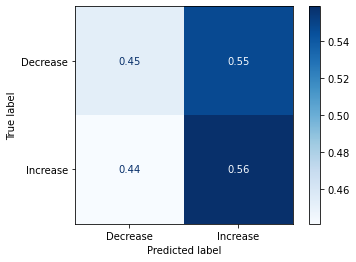

In [65]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train_tfidf,y_train)

## Get predictions
y_hat_test = dummy.predict(X_test_tfidf)
y_hat_train = dummy.predict(X_train_tfidf)
evaluate_model(y_test,y_hat_test,X_test_tfidf,dummy)

### RandomForest

              precision    recall  f1-score   support

    Decrease       0.77      0.79      0.78       117
    Increase       0.81      0.80      0.81       136

    accuracy                           0.79       253
   macro avg       0.79      0.79      0.79       253
weighted avg       0.79      0.79      0.79       253



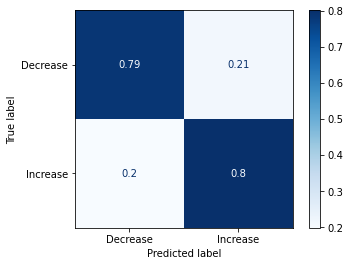

In [66]:
from sklearn.ensemble import RandomForestClassifier
## Make and fit a random forest
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_tfidf,y_train)

## Get predictions
y_hat_test = rf.predict(X_test_tfidf)
y_hat_train = rf.predict(X_train_tfidf)

## Evaluate MOdel
evaluate_model(y_test,y_hat_test,X_test_tfidf,rf)

### GridSearch RF

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer

tokenizer = nltk.TweetTokenizer(preserve_case=False)
vectorizer = TfidfVectorizer()#tokenizer=tokenizer.tokenize,
#                             stop_words=stopwords_list)
rf_pipe = Pipeline(steps=[
    ('vectorizer',vectorizer),
    ('rf',RandomForestClassifier(class_weight='balanced'))
])
rf_pipe

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('rf', RandomForestClassifier(class_weight='balanced'))])

In [68]:
params = {'vectorizer__tokenizer':[None,tokenizer.tokenize],
         'vectorizer__stop_words':[None,stopwords_list],
         'vectorizer__use_idf':[True,False],
          'vectorizer__smooth_idf':[True,False]}

grid = GridSearchCV(rf_pipe, params,cv=3,n_jobs=-1)#,scoring='recall_macro')
grid

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'vectorizer__smooth_idf': [True, False],
                         'vectorizer__stop_words': [None,
                                                    ['i', 'me', 'my', 'myself',
                                                     'we', 'our', 'ours',
                                                     'ourselves', 'you',
                                                     "you're", "you've",
                                                     "you'll", "you'd", 'your',
                                                     'yours', 'yourself',
                                                     'yourselves', 'he', 'him',
                                                     'his', 'himself', 'she',
         

In [69]:
grid.fit(X_train,y_train)
grid.best_params_

{'vectorizer__smooth_idf': False,
 'vectorizer__stop_words': None,
 'vectorizer__tokenizer': None,
 'vectorizer__use_idf': True}

In [70]:
target_map

{'Twitter for iPhone': 0, 'Twitter for Android': 1}

In [71]:
# trump_classes = ['Not Trump','Trump']

              precision    recall  f1-score   support

    Decrease       0.97      0.73      0.83       117
    Increase       0.81      0.98      0.88       136

    accuracy                           0.86       253
   macro avg       0.89      0.85      0.86       253
weighted avg       0.88      0.86      0.86       253



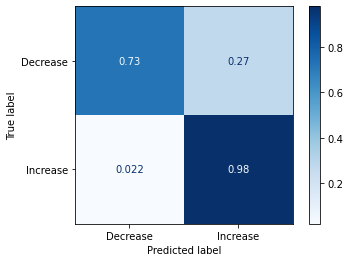

In [72]:
best_pipe = grid.best_estimator_
y_hat_test = best_pipe.predict(X_test)
evaluate_model(y_test,y_hat_test,X_test,best_pipe)

## Naive Bayes

In [73]:
def fit_evaluate_model(model,X_train,y_train,X_test):
    model.fit(X_train,y_train)

    ## Get predictions
    y_hat_test = model.predict(X_test)

    ## Evaluate MOdel
    evaluate_model(y_test,y_hat_test,X_test,model)
    return model

              precision    recall  f1-score   support

    Decrease       0.94      0.53      0.68       117
    Increase       0.71      0.97      0.82       136

    accuracy                           0.77       253
   macro avg       0.82      0.75      0.75       253
weighted avg       0.81      0.77      0.75       253



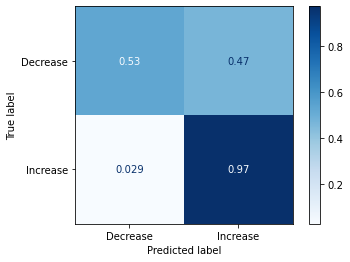

In [74]:
from sklearn.naive_bayes import MultinomialNB
bayes = fit_evaluate_model(MultinomialNB(),X_train_tfidf,y_train,X_test_tfidf)

## Neural Networks

In [75]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.utils import to_categorical

text_data = data_df['text']#.tolist()

# Changed for class imblanace  #
if data_df['target'].nunique()>2:
    y = to_categorical(data_df['target'])#,num_classes=3)
else:
    y = data_df['target'].values
print(f'y.shape={y.shape}')

y.shape=(1009,)


In [76]:
tokenizer = Tokenizer()

## FIGURE OUT WHICH VERSION TO USE WITH SERIES:
tokenizer.fit_on_texts(text_data)
# return integer-encoded sentences
X = tokenizer.texts_to_sequences(text_data)
X = sequence.pad_sequences(X)

MAX_SEQUENCE_LENGTH = X.shape[1]
print(f'Sequence length: {MAX_SEQUENCE_LENGTH}')

## Save word indices
word_index = tokenizer.index_word
reverse_index = {v:k for k,v in word_index.items()}

Sequence length: 32


In [77]:
## Train test split
X_train, X_test,y_train,y_test = train_test_split(X, y, test_size=0.15,random_state=321)#, val_size=0.15)


In [78]:
def get_class_balances(y_train, y_test,show_styler=False):
    if y_train.ndim >1:
        ## Final Class Balance Check
        class_balance = pd.DataFrame({'y_train':pd.Series(y_train.argmax(1)).value_counts(1),
                      'y_test':pd.Series(y_test.argmax(1)).value_counts(1)})#,index=classes)

    else:
        class_balance = pd.DataFrame({'y_train':pd.Series(y_train).value_counts(1),
                  'y_test':pd.Series(y_test).value_counts(1)})#,index=classes)

    # class_balance.index=classes
    class_balance.index = class_balance.index.map(target_map_lookup)
    if show_styler:
        display(class_balance.style.background_gradient())

#     else:
    return class_balance
    
class_balance = get_class_balances(y_train,y_test,1)
class_balance.reset_index(inplace=True)

,y_train,y_test
Twitter for Android,0.560093,0.526316
Twitter for iPhone,0.439907,0.473684


In [79]:
# if y_train.ndim >1:
#     ## Final Class Balance Check
#     class_balance = pd.DataFrame({'y_train':pd.Series(y_train.argmax(1)).value_counts(1),
#                   'y_test':pd.Series(y_test.argmax(1)).value_counts(1)})#,index=classes)
    
# else:
#     class_balance = pd.DataFrame({'y_train':pd.Series(y_train).value_counts(1),
#               'y_test':pd.Series(y_test).value_counts(1)})#,index=classes)
# # class_balance.index=classes
# class_balance.index = class_balance.index.map(target_map_lookup)
# display(class_balance.style.background_gradient())

### Reference
https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

In [80]:
class_balance['y_train'].max()

0.5600933488914819

In [81]:
from tensorflow.keras import callbacks, models, layers, optimizers, regularizers

## EarlyStopping Callback
earlystopping = callbacks.EarlyStopping( monitor='val_loss',
    min_delta=class_balance['y_train'].max(),
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,)

In [82]:
n_classes = y_train.ndim
n_classes

1

In [83]:
len(target_map_lookup)

2

In [100]:
def evaluate_network(y_true,X_test,model,binary=True,
                     classes=['Not Trump','Trump']):#target_map.keys()):
    
    ## Get Predictions 
    y_pred = model.predict(X_test)
    
    ## Make sure y data is sklearn compatible
    if y_true.ndim>1:
        y_test = y_true.argmax(1)
    else:
        y_test = y_true#.round()
        
    if binary:
        y_hat_test = y_pred.flatten().round()    
    else:
        y_hat_test = y_pred.argmax(1)
        
    
    ## Print Classification Report
    print(metrics.classification_report(y_test,y_hat_test))


    ## Get Normalzied Confusion Matrix
    cm = metrics.confusion_matrix(y_test,y_hat_test,normalize='true')

    ## Make Conf Matr Df To Display
    cm_df =pd.DataFrame(cm,index=classes,columns=classes)
    
    sns.heatmap(cm_df,annot=True,cmap='Blues')
#     display(cm_df.style.background_gradient(axis=1).set_caption('Normalized Confusion Matrix'))


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 32, 100)           419800    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 32, 100)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32, 50)            30200     
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 470,251
Trainable params: 470,251
Non-trainable params: 0
_________________________________________________________________


None

Final Layer Act Func= sigmoid; Loss Func= binary_crossentropy


Epoch 1/10
22/22 [==============================] - 2s 68ms/step - loss: 9.9776 - acc: 0.6102 - val_loss: 7.2418 - val_acc: 0.7151
Epoch 2/10
22/22 [==============================] - 1s 57ms/step - loss: 5.6785 - acc: 0.7825 - val_loss: 4.2027 - val_acc: 0.7326
Epoch 3/10
22/22 [==============================] - 1s 49ms/step - loss: 3.2175 - acc: 0.8102 - val_loss: 2.3583 - val_acc: 0.8488
Epoch 4/10
22/22 [==============================] - 1s 48ms/step - loss: 1.6952 - acc: 0.8861 - val_loss: 1.2456 - val_acc: 0.8547
Epoch 5/10
22/22 [==============================] - 1s 68ms/step - loss: 0.8363 - acc: 0.9036 - val_loss: 0.7282 - val_acc: 0.8430
Epoch 6/10
22/22 [==============================] - 1s 50ms/step - loss: 0.4243 - acc: 0.9241 - val_loss: 0.5295 - val_acc: 0.8256
Epoch 7/10
22/22 [==============================] - 1s 46ms/step - loss: 0.2821 - acc: 0.9255 - val_loss: 0.4700 - val_acc: 0.8488
Epoch 8/10
22/22 [=

<AxesSubplot:>

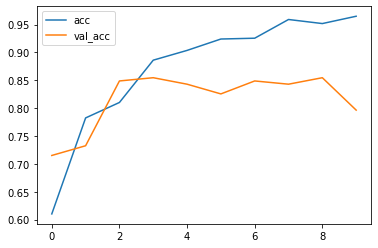

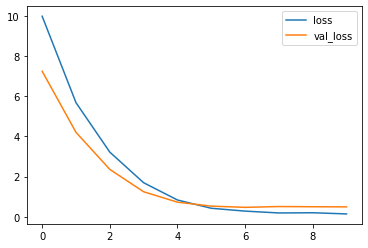

In [101]:
## Make model infrastructure:
model0 = models.Sequential()

## Get and add embedding_layer
model0.add(layers.Embedding(input_dim=len(tokenizer.word_index)+1,
                            input_length=MAX_SEQUENCE_LENGTH,output_dim=100))
model0.add(layers.SpatialDropout1D(0.2))
model0.add(layers.LSTM(units=50, dropout=0.5,recurrent_dropout=0.3,return_sequences=True,
                       kernel_regularizer=regularizers.l2(.1)))
# model0.add(layers.SpatialDropout1D(0.2))
model0.add(layers.LSTM(units=50, dropout=0.5,recurrent_dropout=0.3,return_sequences=False))#,
#                        kernel_regularizer=regularizers.l2(.1)))
# model0_wv.add(layers.Bidirectional(layers.LSTM(units=100, return_sequences=True,
#                        dropout=0.5,recurrent_dropout=0.2,
# #                        kernel_regularizer=regularizers.l2(.01))))
# model0.add(layers.Bidirectional(layers.LSTM(units=100, return_sequences=False,
#                        dropout=0.3,recurrent_dropout=0.2,
#                        kernel_regularizer=regularizers.l2(.01))))

##Save n_classes to programmatically change the final layer and loss functions
y_dim = y_train.ndim

if y_dim>1:
    act_func = 'softmax'
    loss_func = 'categorical_crossentropy'
    n_classes = len(target_map_lookup)

else:
    act_func = 'sigmoid'
    loss_func = 'binary_crossentropy'
    n_classes = 1
    
## Add Final Layers and Compile    
model0.add(layers.Dense(n_classes,activation=act_func))#3

model0.compile(loss=loss_func,optimizer="rmsprop",metrics=['acc']) #optimizer="rmsprop"

## Display summary and parans set using n_classes
display(model0.summary())
print(f"Final Layer Act Func= {act_func}; Loss Func= {loss_func}\n\n")

## Fit Model and Visualize History
history = model0.fit(X_train,y_train,batch_size=32,epochs=10,validation_split=0.2,
                    callbacks=[earlystopping])

res_df = pd.DataFrame(history.history)#.plot()
res_df[[c for c in res_df.columns if 'acc' in c]].plot()
res_df[[c for c in res_df.columns if 'loss' in c]].plot()

              precision    recall  f1-score   support

           0       0.73      0.89      0.80        72
           1       0.88      0.70      0.78        80

    accuracy                           0.79       152
   macro avg       0.80      0.79      0.79       152
weighted avg       0.81      0.79      0.79       152



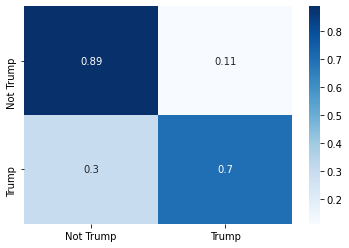

In [102]:
evaluate_network(y_test,X_test,model0,binary=True)

# BOOKMARK

## NEXT: USE GLOVE TWITTER EMBEDDINGS

In [103]:
glove = '/Users/jamesirving/Datasets/glove.twitter.27B/'
os.listdir(glove)

['glove.twitter.27B.100d.txt',
 'glove.twitter.27B.50d.txt',
 'glove_to_w2vec.txt',
 'glove.twitter.27B.25d.txt',
 'glove.twitter.27B.200d.txt']

In [104]:
# embedding_file = glove+'glove.twitter.27B.100d.txt'
# embedding_file

In [ ]:
## Load in saved glove vectors using KeyedVectors.load_word2vec_format()
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

## Save Glove Twitter Vectors to A Glove File For Word Math
folder_for_vectors ='/Users/jamesirving/Datasets/glove.twitter.27B/'
glove_file = 'glove.twitter.27B.100d.txt'

# define full input glove and output word2vec filepaths
glove_filepath = folder_for_vectors+glove_file
w2v_filepath = folder_for_vectors+'glove_to_w2vec.txt'

glove2word2vec(glove_filepath,w2v_filepath)
glovew2v_model = KeyedVectors.load_word2vec_format(w2v_filepath)
wvg = glovew2v_model.wv

In [ ]:
help(wvg)

In [ ]:
## Getting embedding layer directly from wvg
glove_embedding = wvg.get_keras_embedding()
help(glove_embedding)

In [ ]:
## Make model infrastructure:
model1 = models.Sequential()

## Get and add embedding_layer
model1.add(wvg.get_keras_embedding())
model1.add(layers.SpatialDropout1D(0.2))
model1.add(layers.LSTM(units=50, dropout=0.5,recurrent_dropout=0.3,return_sequences=True,
                       kernel_regularizer=regularizers.l2(.1)))
# model0.add(layers.SpatialDropout1D(0.2))
model1.add(layers.LSTM(units=50, dropout=0.5,recurrent_dropout=0.3,return_sequences=False))#,

##Save n_classes to programmatically change the final layer and loss functions
y_dim = y_train.ndim

if y_dim>1:
    act_func = 'softmax'
    loss_func = 'categorical_crossentropy'
    n_classes = len(target_map_lookup)

else:
    act_func = 'sigmoid'
    loss_func = 'binary_crossentropy'
    n_classes = 1
    
## Add Final Layers and Compile    
model1.add(layers.Dense(n_classes,activation=act_func))#3

model1.compile(loss=loss_func,optimizer="rmsprop",metrics=['acc']) #optimizer="rmsprop"

## Display summary and parans set using n_classes
display(model1.summary())
print(f"Final Layer Act Func= {act_func}; Loss Func= {loss_func}\n\n")

## Fit Model and Visualize History
history = model1.fit(X_train,y_train,batch_size=32,epochs=10,validation_split=0.2,
                    callbacks=[earlystopping])

display(evaluate_network(y_test,X_test,model1,binary=True))

res_df = pd.DataFrame(history.history)#.plot()
res_df[[c for c in res_df.columns if 'acc' in c]].plot()
res_df[[c for c in res_df.columns if 'loss' in c]].plot()

# APPENDIX

### Testing code to make evalute_network

In [87]:
# y_true = y_test
# binary=True

# ## Get Predictions and Classification Report
# y_pred = model0.predict(X_test)
# y_true.shape, y_pred.shape

In [88]:
# ## Make sure y data is sklearn compatible
# if y_true.ndim>1:
#     y_true = y_true.argmax(1)

# # else:
# #     y_test = y_true#.round()

# if binary:
#     y_hat_test = y_pred.flatten().round()    

# else:
#     y_hat_test = y_pred.argmax(1)
    
# y_true.shape, y_hat_test.shape

In [89]:
# print(metrics.classification_report(y_true,y_hat_test))

In [90]:
# ## Get Normalzied Confusion Matrix
# cm = metrics.confusion_matrix(y_test.argmax(1),y_hat_test.argmax(1),normalize='true')
# classes = ['Decrease','Increase']

# ## Make Conf Matr Df To Display
# cm_df =pd.DataFrame(cm,index=classes,columns=classes)
# cm_df.style.background_gradient(axis=1)

## Other Networks

In [ ]:
stop

In [ ]:
## GRU Model
from tensorflow.keras import models, layers, optimizers, regularizers
model0B = models.Sequential()

## Get and add embedding_layer
# embedding_layer = ji.make_keras_embedding_layer(wv, X_train)
model0B.add(embedding_layer_gl)

model0B.add(layers.SpatialDropout1D(0.5))
model0B.add(layers.Bidirectional(layers.GRU(units=100, dropout=0.5, recurrent_dropout=0.2,return_sequences=True)))
model0B.add(layers.Bidirectional(layers.GRU(units=100, dropout=0.5, recurrent_dropout=0.2)))
model0B.add(layers.Dense(3, activation='softmax'))

model0B.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['acc'])#,'val_acc'])#, callbacks=callbacks)
model0B.summary()